Youtube Data Analysis Project

1. We will be importing our basic libraries and functions in it.

In [2]:
import pandas as pd
import numpy as np
import json
from dateutil import parser
import isodate

# Google API for data 
from googleapiclient.discovery import build

# Libraries for Data Visualization
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
sns.set(style="darkgrid", color_codes=True)

# Some NLP libraries
import nltk 
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
# from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\PRABHAT\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\PRABHAT\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

2. Now We will bw creating an function for calling data from the youtube api. 

In [3]:
def youtube_api_runner(): 
    api_key = ''

    youtube_data = build('youtube', 'v3', developerKey=api_key)
    return youtube_data

3. Now we will be defining some functions here for different type of data we want to check or perform transformation on. 

In [17]:
def get_channel_stats(youtube_data, channel_ids): 
    all_data = []

    request = youtube_data.channels().list(
        part='snippet,contentDetails,statistics', 
        id=','.join(channel_ids))
    response = request.execute()

    for i in range(len(response['items'])):
        data = dict(channelName = response['items'][i]['snippet']['title'],
                    subscribers = response['items'][i]['statistics']['subscriberCount'],
                    views = response['items'][i]['statistics']['viewCount'],
                    totalVideos = response['items'][i]['statistics']['videoCount'],
                    playListId = response['items'][i]['contentDetails']['relatedPlaylists']['uploads'])

        all_data.append(data)

    return pd.DataFrame(all_data)


# Get video is from youtube data based on the playlist ids
def get_video_ids(youtube, playlist_id):
    request = youtube.playlistItems().list(
                part='contentDetails',
                playlistId = playlist_id,
                maxResults = 50)
    response = request.execute()
    
    video_ids = []
    
    for i in range(len(response['items'])):
        video_ids.append(response['items'][i]['contentDetails']['videoId'])
        
    next_page_token = response.get('nextPageToken')
    more_pages = True
    
    while more_pages:
        if next_page_token is None:
            more_pages = False
        else:
            request = youtube.playlistItems().list(
                        part='contentDetails',
                        playlistId = playlist_id,
                        maxResults = 50,
                        pageToken = next_page_token)
            response = request.execute()
    
            for i in range(len(response['items'])):
                video_ids.append(response['items'][i]['contentDetails']['videoId'])
            
            next_page_token = response.get('nextPageToken')
        
    return video_ids

# Get video details based on video IDs that we will be passing.
def get_video_data(youtube, video_ids):
    all_videos_info = []

    for i in range(0, len(video_ids), 50):
        request = youtube.videos().list(
            part="snippet,contentDetails,statistics",
            id=','.join(video_ids[i:i+50])
        )
        response = request.execute() 

        for video in response['items']:
            stats_to_keep = {'snippet':['channelTitle', 'title', 'description', 'tags', 'publishedAt'],
                            'contentDetails':['duration', 'definition', 'caption'],
                            'statistics':['viewCount', 'likeCount', 'favouriteCount', 'commentCount']}

            video_info = {}
            video_info['video_id'] = video['id']

            for k in stats_to_keep.keys():
                for v in stats_to_keep[k]:
                    try:
                        video_info[v] = video[k][v]
                    except:
                        video_info[v] = None

            all_videos_info.append(video_info)

    return pd.DataFrame(all_videos_info)

In [18]:
youtube_data = youtube_api_runner()

4. Here we will be calling all the method for getting the channel statistics data using channel ids. 

In [19]:
channel_ids = [
        'UCtYLUTtgS3k1Fg4y5tAhLbw', # Statquest
        'UCCezIgC97PvUuR4_gbFUs5g', # Corey Schafer
        'UCfzlCWGWYyIQ0aLC5w48gBQ', # Sentdex
        'UCNU_lfiiWBdtULKOw6X0Dig', # Krish Naik
        'UCzL_0nIe8B4-7ShhVPfJkgw', # DatascienceDoJo
        'UCLLw7jmFsvfIVaUFsLs8mlQ', # Luke Barousse 
        'UCiT9RITQ9PW6BhXK0y2jaeg', # Ken Jee
        'UC7cs8q-gJRlGwj4A8OmCmXg', # Alex the analyst
        'UC2UXDak6o7rBm23k3Vv5dww', # Tina Huang
    ]
# youtube_data_json = json.load(youtube_data)
# youtube_data_json = pd.DataFrame()
# youtube_data_json

channel_data = get_channel_stats(youtube_data, channel_ids)
channel_data

,channelName,subscribers,views,totalVideos,playListId
0,Corey Schafer,1240000,91227597,232,UUCezIgC97PvUuR4_gbFUs5g
1,sentdex,1280000,112693510,1249,UUfzlCWGWYyIQ0aLC5w48gBQ
2,Luke Barousse,396000,19084981,147,UULLw7jmFsvfIVaUFsLs8mlQ
3,Krish Naik,849000,86038378,1756,UUNU_lfiiWBdtULKOw6X0Dig
4,StatQuest with Josh Starmer,1050000,57288776,266,UUtYLUTtgS3k1Fg4y5tAhLbw
5,Data Science Dojo,101000,5730983,455,UUzL_0nIe8B4-7ShhVPfJkgw
6,Ken Jee,255000,8733131,286,UUiT9RITQ9PW6BhXK0y2jaeg
7,Alex The Analyst,644000,27352416,269,UU7cs8q-gJRlGwj4A8OmCmXg
8,Tina Huang,594000,27385332,164,UU2UXDak6o7rBm23k3Vv5dww


In [21]:
# type(channel_data[subscribers])
numeric_cols = ['subscribers', 'views', 'totalVideos']
channel_data[numeric_cols] = channel_data[numeric_cols].apply(pd.to_numeric, errors='coerce')

C:\Users\PRABHAT\AppData\Local\Temp\ipykernel_19036\601139965.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot = ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)


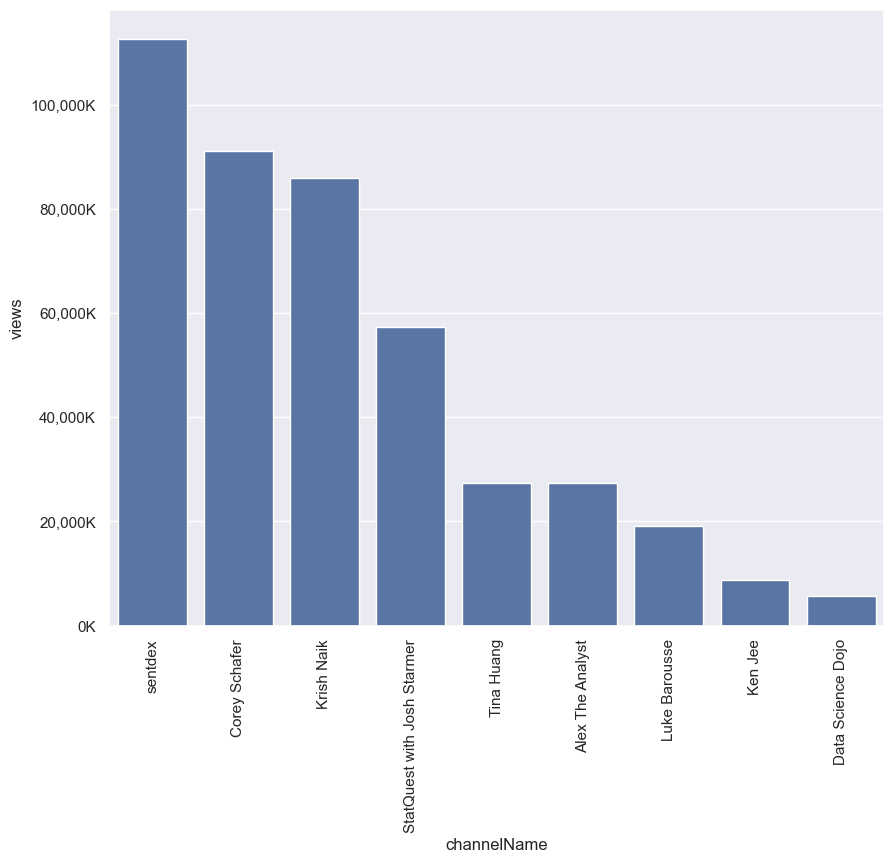

In [22]:
sns.set(rc={'figure.figsize':(10,8)})

ax = sns.barplot(x='channelName', y='views', data=channel_data.sort_values('views', ascending=False))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000) + 'K'))
plot = ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)

C:\Users\PRABHAT\AppData\Local\Temp\ipykernel_19036\1567007160.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


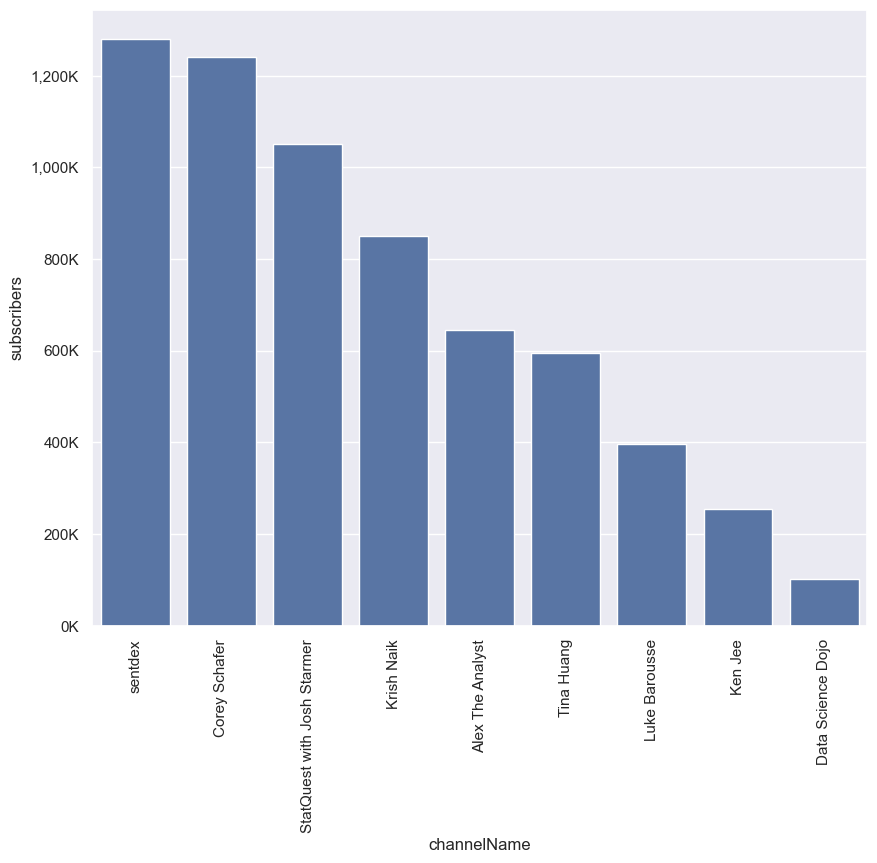

In [23]:
ax = sns.barplot(x='channelName', y='subscribers', data=channel_data.sort_values('subscribers', ascending=False))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000) + 'K'))
plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

5. Now we will be fetching video statistics and comments data for all the listed channels.

In [29]:
video_data_df = pd.DataFrame()
comments_data_df = pd.DataFrame()

for channel in channel_data['channelName'].unique():
    print("Getting video information from channel: " + channel)
    playlist_id = channel_data.loc[channel_data['channelName'] == channel, 'playListId'].iloc[0]
    video_ids = get_video_ids(youtube_data, playlist_id)

    video_data = get_video_data(youtube_data, video_ids)
    # comments_data = get_comments_data(youtube_data, video_ids)

    video_data_df = pd.concat([video_data_df, video_data], ignore_index=True)
    # comments_data_df.append(comments_data, ignore_index=True)

video_data_df

Getting video information from channel: Corey Schafer
Getting video information from channel: sentdex
Getting video information from channel: Luke Barousse
Getting video information from channel: Krish Naik
Getting video information from channel: StatQuest with Josh Starmer
Getting video information from channel: Data Science Dojo
Getting video information from channel: Ken Jee
Getting video information from channel: Alex The Analyst
Getting video information from channel: Tina Huang


,video_id,channelTitle,title,description,tags,publishedAt,duration,definition,caption,viewCount,likeCount,favouriteCount,commentCount
0,jRAAaDll34Q,Corey Schafer,How to Use ChatGPT as a Powerful Tool for Prog...,"In this Programming Tutorial video, we will be...","[ChatGPT, chatgpt for programmers, AI for deve...",2023-05-21T21:00:10Z,PT31M8S,hd,false,259592,7302,None,433
1,HZ8uXq5VG2w,Corey Schafer,Python Tutorial: Simulate the Powerball Lotter...,"In this Python Programming video, we will be l...","[python, lottery, powerball, simulation, pytho...",2023-01-09T18:45:00Z,PT38M56S,hd,false,133196,4205,None,774
2,vQQEaSnQ_bs,Corey Schafer,Python YouTube API Tutorial: Using OAuth to Ac...,"In this Python Programming Tutorial, we'll be ...","[python, youtube api, youtube-api, youtube oau...",2020-09-10T14:15:03Z,PT43M21S,hd,false,137681,2647,None,351
3,1KO_HZtHOWI,Corey Schafer,Python YouTube API Tutorial: Sort a Playlist b...,"In this Python Programming Tutorial, we'll be ...","[python, youtube api, youtube-api, youtube pla...",2020-07-31T14:30:00Z,PT22M8S,hd,false,45359,1095,None,128
4,coZbOM6E47I,Corey Schafer,Python YouTube API Tutorial: Calculating the D...,"In this Python Programming Tutorial, we'll be ...","[python, youtube api, youtube-api, python yout...",2020-06-10T15:53:26Z,PT37M38S,hd,false,55275,1592,None,177
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4769,mueI-I7Suxw,Tina Huang,"3rd Year Statistics, Data Science, Computer S...",You should watch this video if you are applyin...,"[data science resume, software engineering res...",2020-08-08T12:08:36Z,PT14M36S,hd,false,7297,201,None,24
4770,-zQ-Pf491bQ,Tina Huang,How I Became a Data Scientist | Computer Scien...,This is part 2 of my internship and job search...,"[upenn, mcit, data science, software engineeri...",2020-08-02T21:44:56Z,PT7M52S,hd,false,16124,451,None,41
4771,Rx1i1J4m4MQ,Tina Huang,How I got Software Engineering and Data Scienc...,I got Amazon and Goldman Sachs internships for...,"[computer science, mcit, upenn, university of ...",2020-07-28T16:48:31Z,PT9M48S,hd,false,31285,1028,None,69
4772,JUkSeqe1eYQ,Tina Huang,How to choose between software engineering and...,Software Engineering vs Data Science? Last yea...,"[data science, software engineering, data scie...",2020-07-22T06:00:57Z,PT7M56S,hd,false,399961,17891,None,682
